In [14]:
import yfinance as yahooFinance
from tensorflow import keras
import numpy as np
import seaborn as sns
from ncps import wirings
from ncps.tf import LTC
import matplotlib.pyplot as plt

In [12]:
def get_data(ticker, period="max"):
    info = yahooFinance.Ticker(ticker)

    # Valid periods are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, and max.
    return info.history(period=period)

data = get_data("META")
y =  data["Close"]
data = data.drop("Close", axis=1)

                                 Open        High         Low     Volume  \
Date                                                                       
2012-05-18 00:00:00-04:00   42.049999   45.000000   38.000000  573576400   
2012-05-21 00:00:00-04:00   36.529999   36.660000   33.000000  168192700   
2012-05-22 00:00:00-04:00   32.610001   33.590000   30.940001  101786600   
2012-05-23 00:00:00-04:00   31.370001   32.500000   31.360001   73600000   
2012-05-24 00:00:00-04:00   32.950001   33.209999   31.770000   50237200   
...                               ...         ...         ...        ...   
2023-12-18 00:00:00-05:00  337.480011  347.559998  337.019989   18993900   
2023-12-19 00:00:00-05:00  345.579987  353.600006  345.119995   17729400   
2023-12-20 00:00:00-05:00  348.649994  354.959991  347.790009   16369900   
2023-12-21 00:00:00-05:00  352.980011  356.410004  349.209991   15289600   
2023-12-22 00:00:00-05:00  355.579987  357.200012  351.220001   11764200   

           

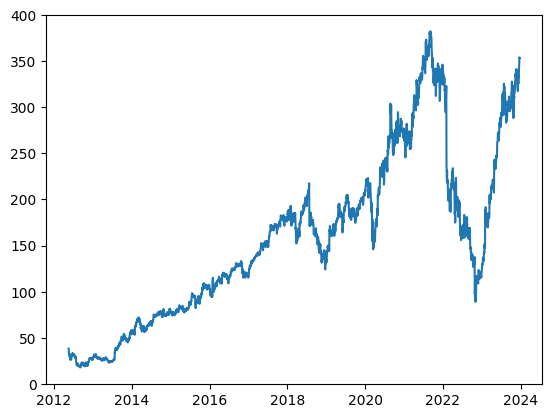

In [13]:
plt.plot(y)
plt.show()